In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Now it's time for another guided example. This time, you're going to look at recipes. Specifically, you'll use the *epicurious* dataset, which has a collection of recipes, key terms, ingredients, and ratings.

What you want to see is if you can use the ingredient and keyword list to predict the rating. For someone writing a cookbook, this could be really useful information. They could use it to identify which recipes are more likely to be enjoyed, which could help them choose which recipes to include to make the book more likely to be successful.

First, load the dataset, which is [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). You'll use the CSV file here; start by pulling out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

You can learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes, with an average rating of 3.71. What is interesting is that the twenty-fifth percentile is actually above the mean. This means that there is likely some kind of outlier population. This makes sense when you think about reviews; some bad recipes may have very few, very low reviews.

Now, use a histogram to validate that idea a bit further.

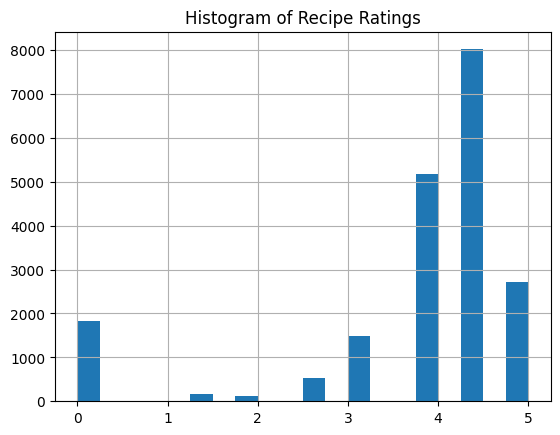

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

This histogram reveals a few things. Firstly, there are sharp discontinuities. You don't have continuous data. No recipe has a 3.5 rating, for example. Also, you can see the anticipated increase at 0.

Now, try a naive approach again, this time using an SVM regressor. But first, you'll have to do a bit of data cleaning.

In [6]:
# Count the nulls
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What you can see right away is that nutrition information is not available for all goods. This would be an interesting data point, but focus on ingredients and keywords right now. So go ahead and drop the whole columns for calories, protein, fat, and sodium. You'll come back to nutrition information later.

In [7]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

<ipython-input-7-87ef74f6ea6b>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)


SVR()

Note that this actually takes quite a while to run, compared to some of the models that you've done before. Be patient—it's because of the number of features that you have.

Now, see what a scatter plot looks like if you compare actual ratings to predicted ratings:

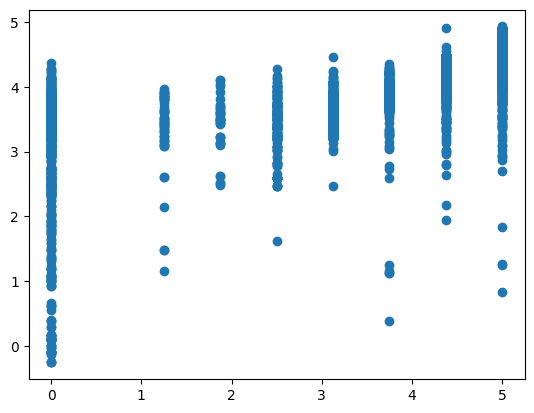

In [8]:
plt.scatter(Y, svr.predict(X))

Now, that is a pretty useless visualization. This is because of the discontinuous nature of the outcome variable. There's too much data for you to really see what's going on here. If you wanted to look at it, you could create histograms. But here, you'll move on to the scores of both the full-fit model and the model with cross-validation. Again, if you choose to run it again, it will take some time—so you probably shouldn't run it again.

In [9]:
svr.score(X, Y)

0.40998459138007937

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([0.19563385, 0.14683481, 0.15013401, 0.13597791, 0.16082192])

Oh dear, this does not seem to have worked very well. In fact, it is remarkably poor! There are many things that you could do here:

* **Approach 1:** The overfit is a problem, even though it was poor in the first place. You could go back and clean up your feature set. There might be some gains to be made by getting rid of the noise.

* **Approach 2:** You could also try removing the nulls but including dietary information, and see how that performs. Though it's a slight change to the question, you could still possibly get some improvements there.

* **Approach 3:** Also, you could take your regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, you might have better luck thinking of this as a classification problem. You could make it simpler still if, instead of classifying on each possible value, you group reviews to some specific high and low values.

**Challenge:** Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.


When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think that it could be biased, perhaps extremely so? There is. There are several things, in fact. But most glaringly, you don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are also more likely to give high reviews. After all, people who eat chocolate might just be happier people.

First, we will isolate the target variable `rating` and look at scores.

In [11]:
raw_data['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

We can now turn our regression problem into a classifier problem.

### Approach 3: Turn our regression problem into a classification problem.

Let's change our dataset so that everything with a rating of 4.2 or higher is "good" and everything below a 4.2 is "not good."

In [12]:
raw_data['good'] = raw_data['rating'].apply(lambda x: 1 if x >=4.2 else 0)
raw_data['good'].value_counts()

1    10738
0     9314
Name: good, dtype: int64

Now let's build a Support Vector Classifier.

In [13]:
from sklearn.svm import SVC
svc = SVC()
X = raw_data.drop(['good','rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data['good'].sample(frac=0.3, replace=True, random_state=1)
svc.fit(X,Y)

<ipython-input-13-1641227d7a7c>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = raw_data.drop(['good','rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)


SVC()

In [14]:
svc.score(X, Y)

0.8602061170212766

In [16]:
cross_val_score(svc, X, Y, cv=5)

array([0.6461794 , 0.64089776, 0.61679135, 0.65502909, 0.6641729 ])